In [1]:
import params, os, funcs
from jaratoolbox import celldatabase, settings
import numpy as np

# %% Load dataframe
databaseDir = os.path.join(settings.DATABASE_PATH, '2024popanalysis')
fullDbPath = 'celldb_2024popanalysis.h5'
fullPath = os.path.join(databaseDir, fullDbPath)
fullDb = celldatabase.load_hdf(fullPath)
simpleSiteNames = fullDb["recordingSiteName"].str.split(',').apply(lambda x: x[0])
simpleSiteNames = simpleSiteNames.replace("Posterior auditory area", "Dorsal auditory area")
fullDb["recordingSiteName"] = simpleSiteNames

In [2]:
X_speech_all, Y_brain_area_speech_all, X_AM_all = [], [], []
Y_brain_area_AM_all, X_pureTones_all, Y_brain_area_PT_all = [], [], []
previous_frequency_speech, previous_frequency_AM, previous_frequency_PT = None, None, None
indices_AM, indices_PT, indices_speech = None, None, None

In [4]:
# Add data to the dictionary for each brain area and sound type
for subject in params.subject_list:
    for date in params.recordingDate_list[subject]:
        for brain_area in params.targetSiteNames:
            speechEnsemble, speechEphys, speechBdata = funcs.load_data(subject, date, brain_area, "FTVOTBorders")

            if speechEnsemble:
                X_speech, Y_brain_area_speech, Y_frequency_speech = funcs.spike_rate("speech", speechEnsemble,
                                                                    speechEphys, speechBdata, brain_area)

                X_speech_array, Y_frequency_speech_sorted, previous_frequency_speech, indices_speech = (
                    funcs.adjust_speech_length(subject, date, brain_area, X_speech, Y_frequency_speech,
                                               Y_brain_area_speech, previous_frequency_speech))

                if X_speech_array is not None:
                    Y_frequency_FT = Y_frequency_speech_sorted[:, 0]
                    Y_frequency_VOT = Y_frequency_speech_sorted[:, 1]

                    # Append the data to the lists
                    X_speech_all.extend(X_speech_array)
                    Y_frequency_speech_2 = Y_frequency_speech_sorted
                    Y_brain_area_speech_all.extend(Y_brain_area_speech)

            # Load and process data for AM
            amEnsemble, amEphys, amBdata = funcs.load_data(subject, date, brain_area, "AM")
            if amEnsemble:
                X_AM, Y_brain_area_AM, Y_frequency_AM = funcs.spike_rate(
                    "AM", amEnsemble, amEphys, amBdata, brain_area)

                # Apply adjustments
                X_AM_adjusted, Y_frequency_AM_adjusted, Yba_AM_adj = (
                    funcs.adjust_array_and_labels(X_AM, Y_frequency_AM, Y_brain_area_AM, 
                                                  params.max_trials['AM'], subject, date, brain_area))

                # Sort arrays
                X_AM_array, Y_frequency_AM_sorted, Y_brain_area_AM_sorted, previous_frequency_AM, indices_AM = (
                    funcs.sort_sound_array(subject, date, brain_area, X_AM_adjusted, Yba_AM_adj, Y_frequency_AM_adjusted, previous_frequency_AM))

                if X_AM_array is not None:
                    # Append the data to the lists
                    X_AM_all.extend(X_AM_array)
                    Y_frequency_AM_2 = Y_frequency_AM_sorted
                    Y_brain_area_AM_all.extend(Y_brain_area_AM_sorted)

            # Load and process data for Pure Tones
            ptEnsemble, ptEphys, ptBdata = funcs.load_data(subject, date, brain_area, "pureTones")
            if ptEnsemble:
                X_pureTones, Y_brain_area_PT, Y_frequency_pureTones = funcs.spike_rate(
                    "PT", ptEnsemble, ptEphys, ptBdata, brain_area)

                # Apply adjustments
                X_PT_adjusted, Y_frequency_PT_adjusted, Yba_PT_adj = (
                    funcs.adjust_array_and_labels(X_pureTones, Y_frequency_pureTones, Y_brain_area_PT,
                                                  params.max_trials['PT'], subject, date, brain_area))

                # Sort arrays
                X_PT_array, Y_frequency_PT_sorted, Y_brain_area_PT_sorted, previous_frequency_PT, indices_PT = (
                    funcs.sort_sound_array(subject, date, brain_area, X_PT_adjusted, Yba_PT_adj, Y_frequency_PT_adjusted, previous_frequency_PT))

                if X_PT_array is not None:
                    # Append the data to the lists
                    X_pureTones_all.extend(X_PT_array)
                    Y_frequency_PT_2 = Y_frequency_PT_sorted
                    Y_brain_area_PT_all.extend(Y_brain_area_PT_sorted)

No FTVOTBorder data for Primary auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Primary auditory area.
No FTVOTBorder data for Dorsal auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Dorsal auditory area.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No FTVOTBorder data for Primary auditory area on 2022-01-19 for feat004
No FTVOTBorder data for Dorsal auditory area on 2022-01-19 for feat004
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-21 for Speech, AM, and PT.
No data in Ven

In [5]:
# %% Sort arrays
X_PT_sorted = funcs.sort_x_arrays(X_pureTones_all, indices_PT, "pt")
X_AM_sorted = funcs.sort_x_arrays(X_AM_all, indices_AM, "am")
X_speech_sorted = funcs.sort_x_arrays(X_speech_all, indices_speech, "speech")

# Convert the lists to numpy arrays for easy manipulation
X_speech_array = np.stack(X_speech_sorted, axis=0)
# X_speech_array = X_speech_array.squeeze(axis=1)
X_AM_array = np.stack(X_AM_sorted, axis=0)
X_PT_array = np.stack(X_PT_sorted, axis=0)

In [6]:
# Initialize a dictionary to store 2D arrays for each brain_area - sound_type combo
data_dict = {}

for brain_area in params.targetSiteNames:
    for sound_type, X_array, Y_brain_area_all, Y_frequency_sorted in zip(
            ['AM', 'PT', 'speech'],
            [X_AM_array, X_PT_array, X_speech_array],
            [Y_brain_area_AM_all, Y_brain_area_PT_all, Y_brain_area_speech_all],
            [Y_frequency_AM_2, Y_frequency_PT_2, Y_frequency_speech_2]):

        # Filter data based on the brain_area
        brain_area_array = np.array(Y_brain_area_all)
        X_array_adjusted = X_array[brain_area_array == brain_area]  # X is neurons x trials

        # Store the 2D array (neurons x trials) in the dictionary
        data_dict[(brain_area, sound_type)] = {
            'X': X_array_adjusted.T,  # Transpose to get the correct shape (neurons x trials)
            'Y': np.array(Y_frequency_sorted)}  # Y is a 1D array of frequencies

# Below is Firing Rate Analysis

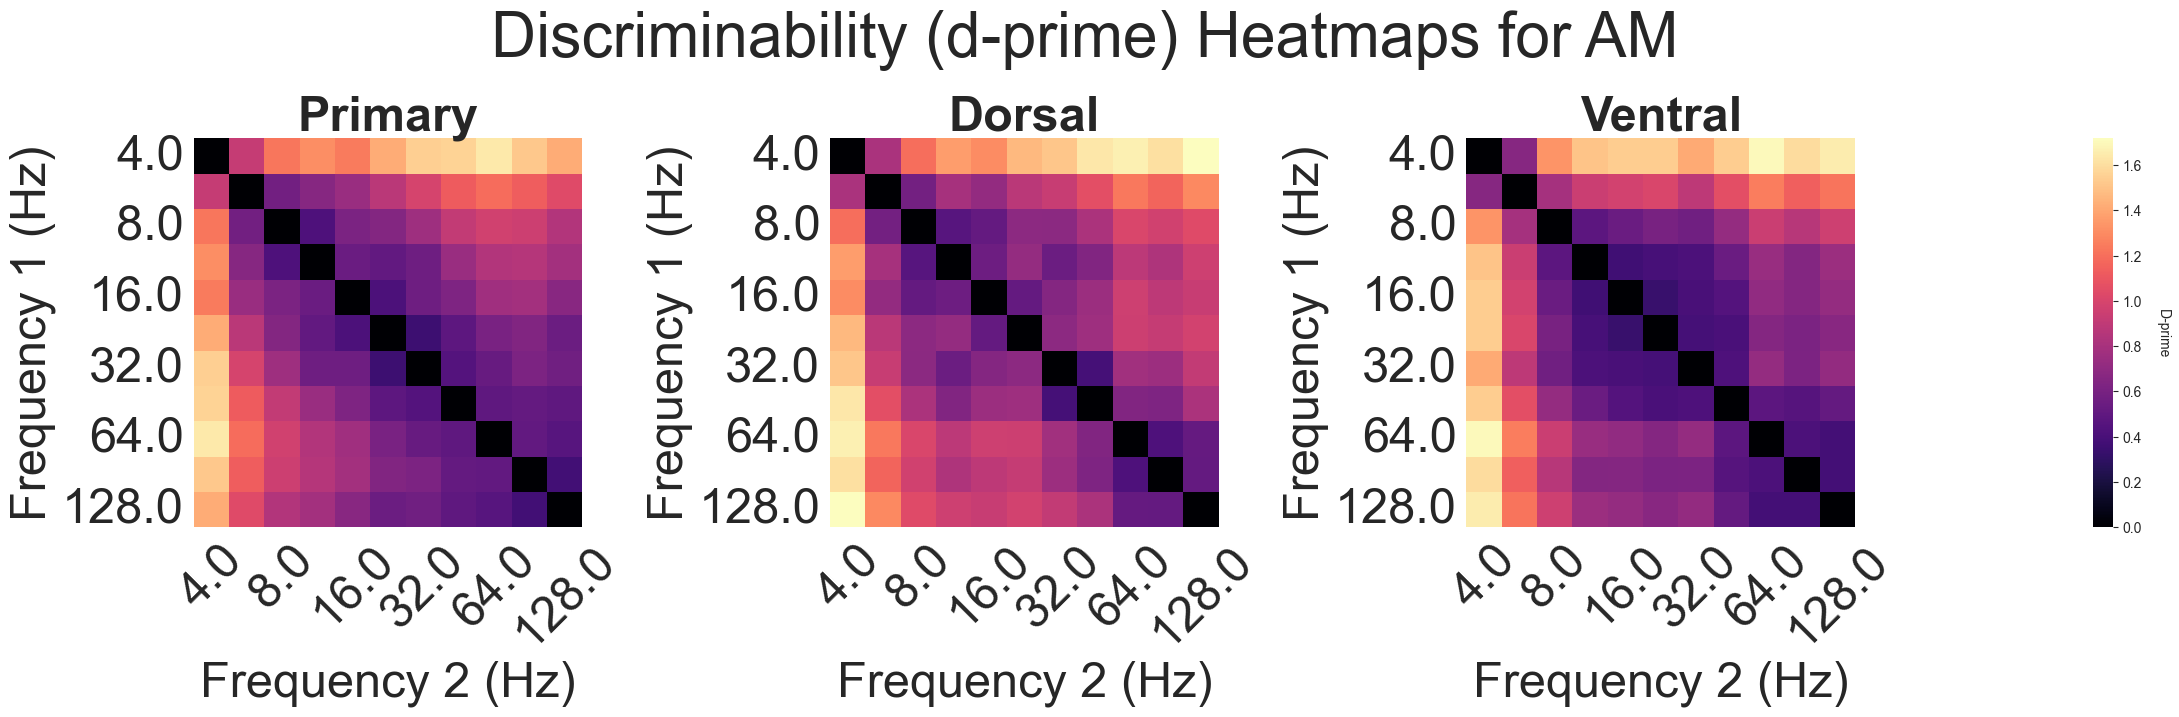

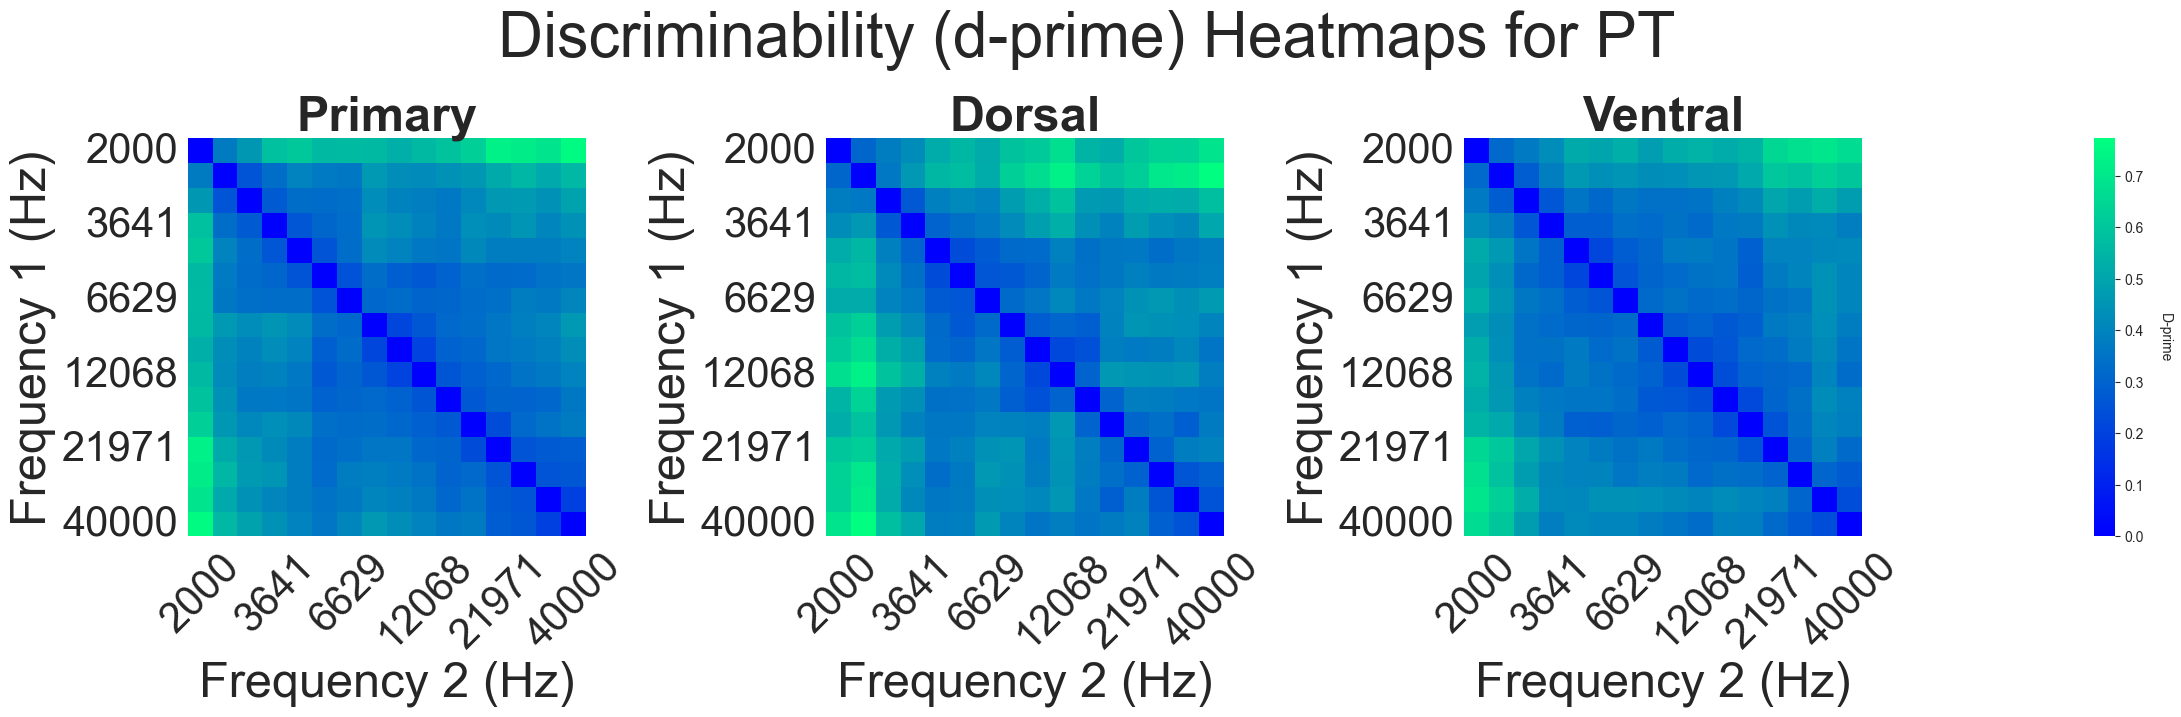

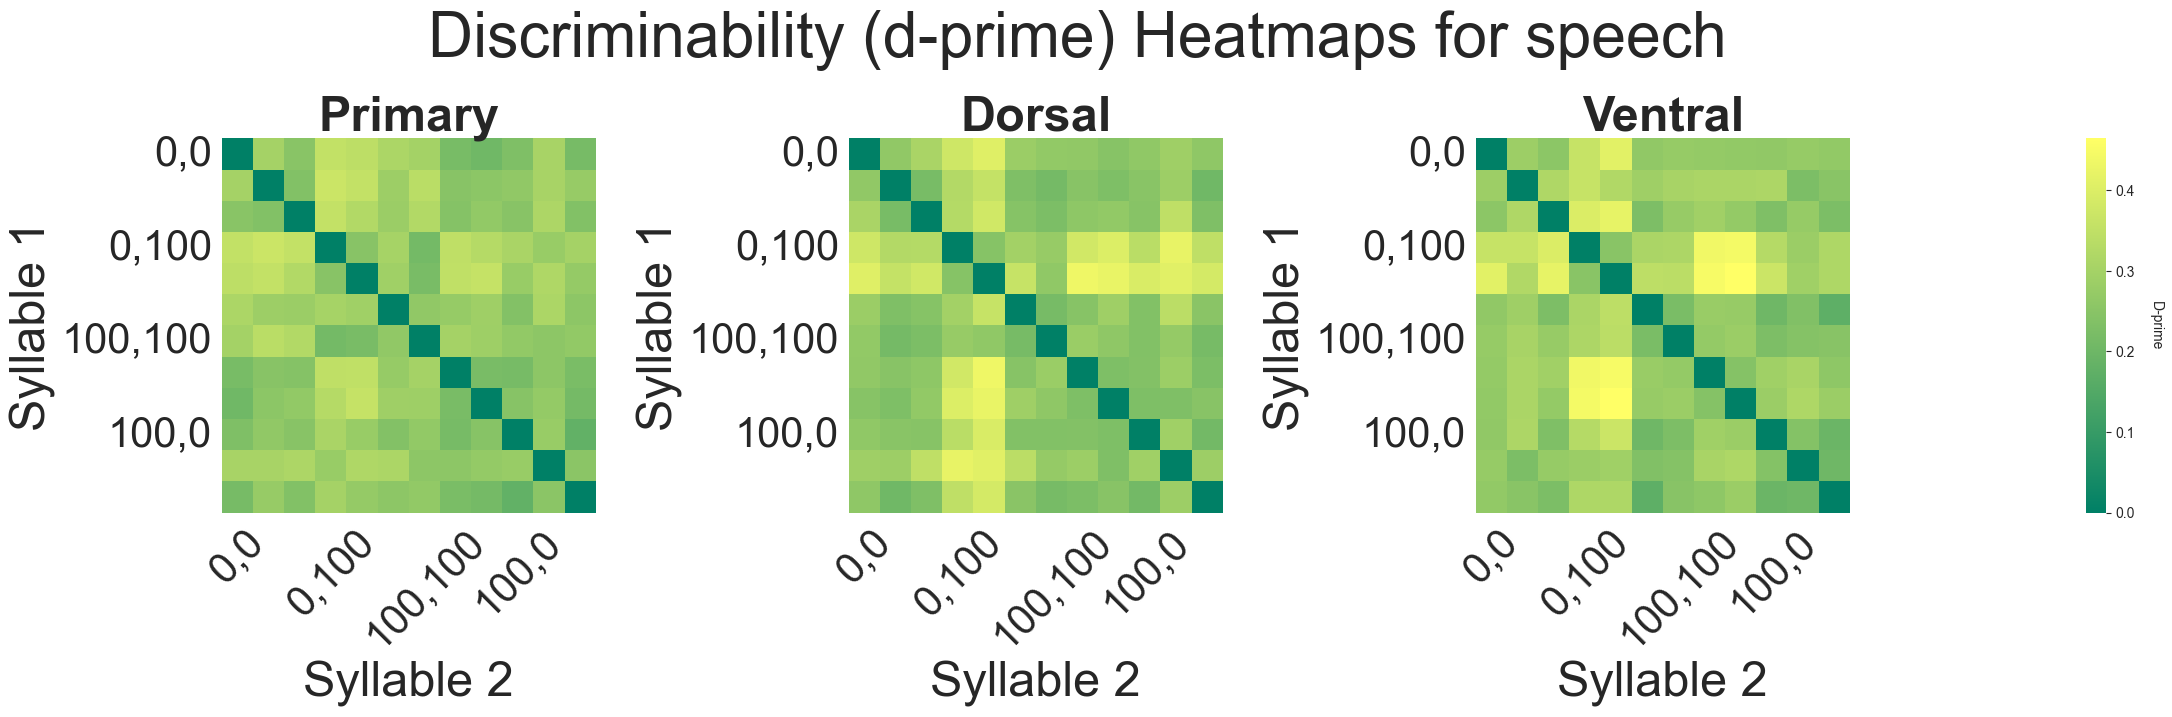

In [7]:
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm

save_path = "/Users/zoetomlinson/Desktop/GitHub/neuronalDataResearch/Figures/Population Plots"
dprime_matrices = {}

# Define color map per sound type
sound_colormaps = {
    'AM': cm.magma,
    'PT': cm.winter,
    'speech': cm.summer
}

short_names = {
    'Primary auditory area': 'Primary',
    'Dorsal auditory area':  'Dorsal',
    'Ventral auditory area': 'Ventral'
}

# Define all unique speech labels (VOT, FT)
unique_labels = [(0, 0), (0, 33), (0, 67), (0, 100), (33, 100), (67, 100),
                 (100, 100), (100, 67), (100, 33), (100, 0), (67, 0), (33, 0)]

for sound_type in ['AM', 'PT', 'speech']:
    dprime_arrays_for_sound = []

    for brain_area in params.targetSiteNames:
        X_array = data_dict[(brain_area, sound_type)]['X']
        Y_array = data_dict[(brain_area, sound_type)]['Y']
        
        if sound_type == 'speech':
            vot_values = Y_array[:, 0]
            ft_values = Y_array[:, 1]
            unique_freqs = unique_labels
        else:
            unique_freqs = sorted(set(Y_array))
        
        dprime_array = np.zeros((len(unique_freqs), len(unique_freqs)))
        
        for i, freq1 in enumerate(unique_freqs):
            for j, freq2 in enumerate(unique_freqs):
                if i == j:
                    continue

                if sound_type == 'speech':
                    mask_freq1 = (vot_values == freq1[0]) & (ft_values == freq1[1])
                    mask_freq2 = (vot_values == freq2[0]) & (ft_values == freq2[1])
                else:
                    mask_freq1 = Y_array == freq1
                    mask_freq2 = Y_array == freq2

                trials_freq1 = X_array[mask_freq1]
                trials_freq2 = X_array[mask_freq2]

                avg_freq1 = np.mean(trials_freq1, axis=0)
                avg_freq2 = np.mean(trials_freq2, axis=0)
                numerator = np.linalg.norm(avg_freq1 - avg_freq2)

                distances_freq1 = np.linalg.norm(trials_freq1 - avg_freq1, axis=1)
                distances_freq2 = np.linalg.norm(trials_freq2 - avg_freq2, axis=1)
                denominator = (np.sum(distances_freq1) + np.sum(distances_freq2)) / (len(distances_freq1) + len(distances_freq2))

                dprime = numerator / denominator if denominator != 0 else 0
                dprime_array[i, j] = dprime

        dprime_matrices[(brain_area, sound_type)] = dprime_array
        dprime_arrays_for_sound.append(dprime_array)

    # Global color scale bounds
    all_vals = np.concatenate([arr.flatten() for arr in dprime_arrays_for_sound])
    global_min, global_max = np.min(all_vals), np.max(all_vals)

    # Setup for shared colorbar using GridSpec
    fig = plt.figure(figsize=(22, 7))
    fig.suptitle(f"Discriminability (d-prime) Heatmaps for {sound_type}", fontsize=45)
    gs = gridspec.GridSpec(1, len(params.targetSiteNames) + 1, width_ratios=[1]*len(params.targetSiteNames) + [0.05])
    axs = [fig.add_subplot(gs[i]) for i in range(len(params.targetSiteNames))]
    cbar_ax = fig.add_subplot(gs[-1])  # Axis for shared colorbar

    # Plot
    for idx, brain_area in enumerate(params.targetSiteNames):
        dprime_array = dprime_matrices[(brain_area, sound_type)]

        if sound_type == 'speech':
            all_labels = [f"{vot},{ft}" for vot, ft in unique_labels]
            label_mask = np.arange(len(all_labels)) % 3 == 0  # Show every other
        elif sound_type == 'PT':
            all_freqs = sorted(set(Y_array))
            all_labels = [str(int(round(val))) for val in all_freqs]  # Round to whole numbers
            label_mask = np.arange(len(all_labels)) % 3 == 0  # Show every 5th
        else:  # AM
            all_freqs = sorted(set(Y_array))
            all_labels = [str(val) for val in all_freqs]
            label_mask = np.arange(len(all_labels)) % 2 == 0  # Show every other
        
        x_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]
        y_labels = [label if show else "" for label, show in zip(all_labels, label_mask)]
        sns.heatmap(dprime_array, cmap=sound_colormaps[sound_type],
                    xticklabels=x_labels, yticklabels=y_labels,
                    vmin=global_min, vmax=global_max,
                    ax=axs[idx], cbar=(idx == 0), cbar_ax=cbar_ax if idx == 0 else None)
            
        # Axis labels and tick size
        if sound_type == "speech":
            axs[idx].set_xlabel("Syllable 2", size=35)
            axs[idx].set_ylabel("Syllable 1", size=35)
            axs[idx].tick_params(axis='x', labelsize=30, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=30, rotation=0)
        elif sound_type == "PT":
            axs[idx].set_xlabel("Frequency 2 (Hz)", size=35)
            axs[idx].set_ylabel("Frequency 1 (Hz)", size=35)
            axs[idx].tick_params(axis='x', labelsize=30, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=30, rotation=0)
        else:
            axs[idx].set_xlabel("Frequency 2 (Hz)", size=35)
            axs[idx].set_ylabel("Frequency 1 (Hz)", size=35)
            axs[idx].tick_params(axis='x', labelsize=35, rotation=45)
            axs[idx].tick_params(axis='y', labelsize=35, rotation=0)

        axs[idx].set_title(f"{brain_area}", fontsize=40, fontweight="bold", y=1.1)
        axs[idx].set_aspect("equal")
        axs[idx].set_title(short_names.get(brain_area, brain_area), fontsize=35, fontweight="bold")

    cbar_ax.set_ylabel('D-prime', rotation=270, labelpad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=0.5, h_pad=1.0)
    filename = f"{sound_type}_all_brain_areas_dprime_heatmap.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, bbox_inches='tight')

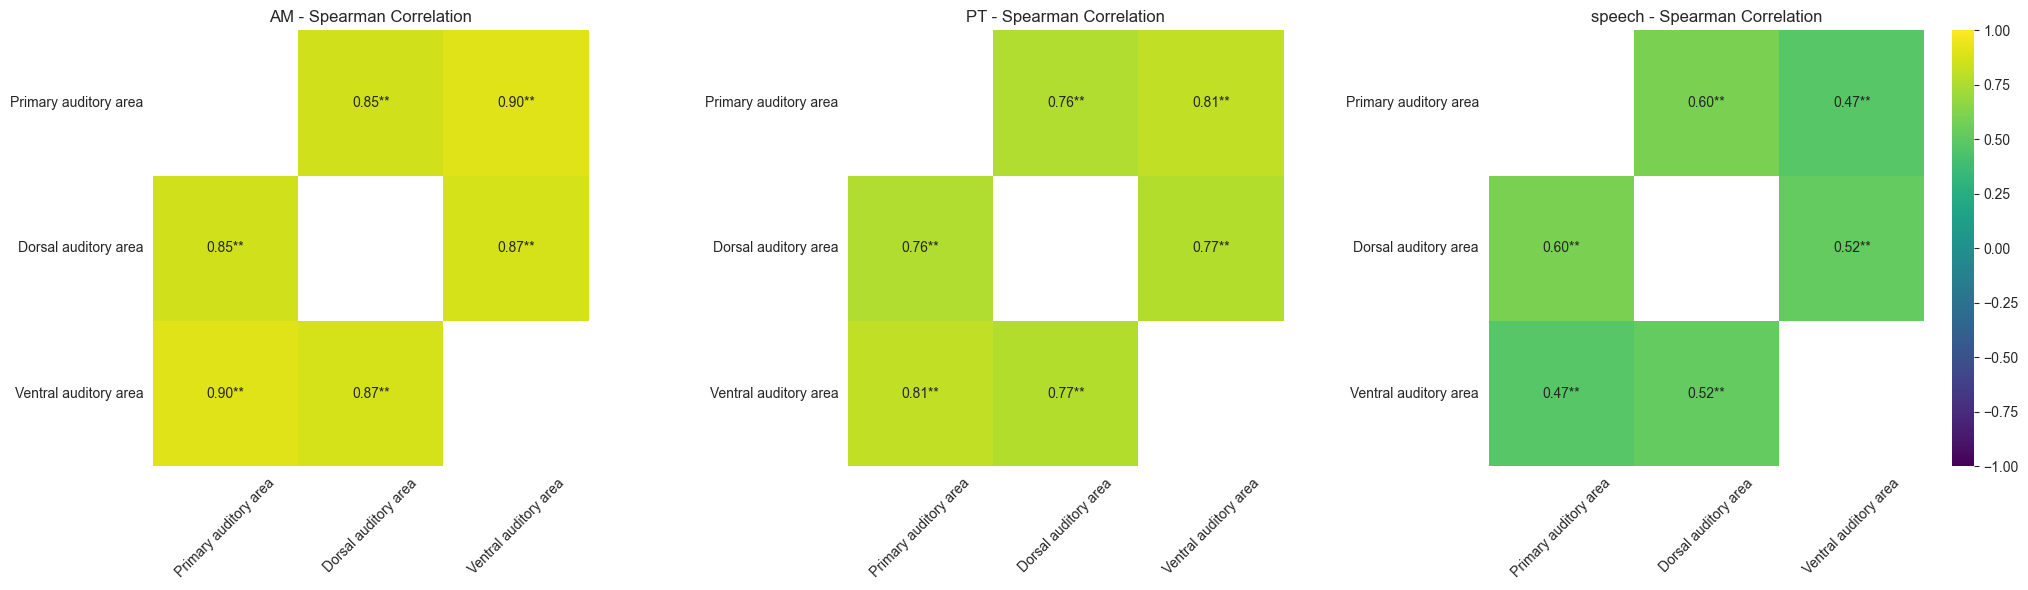

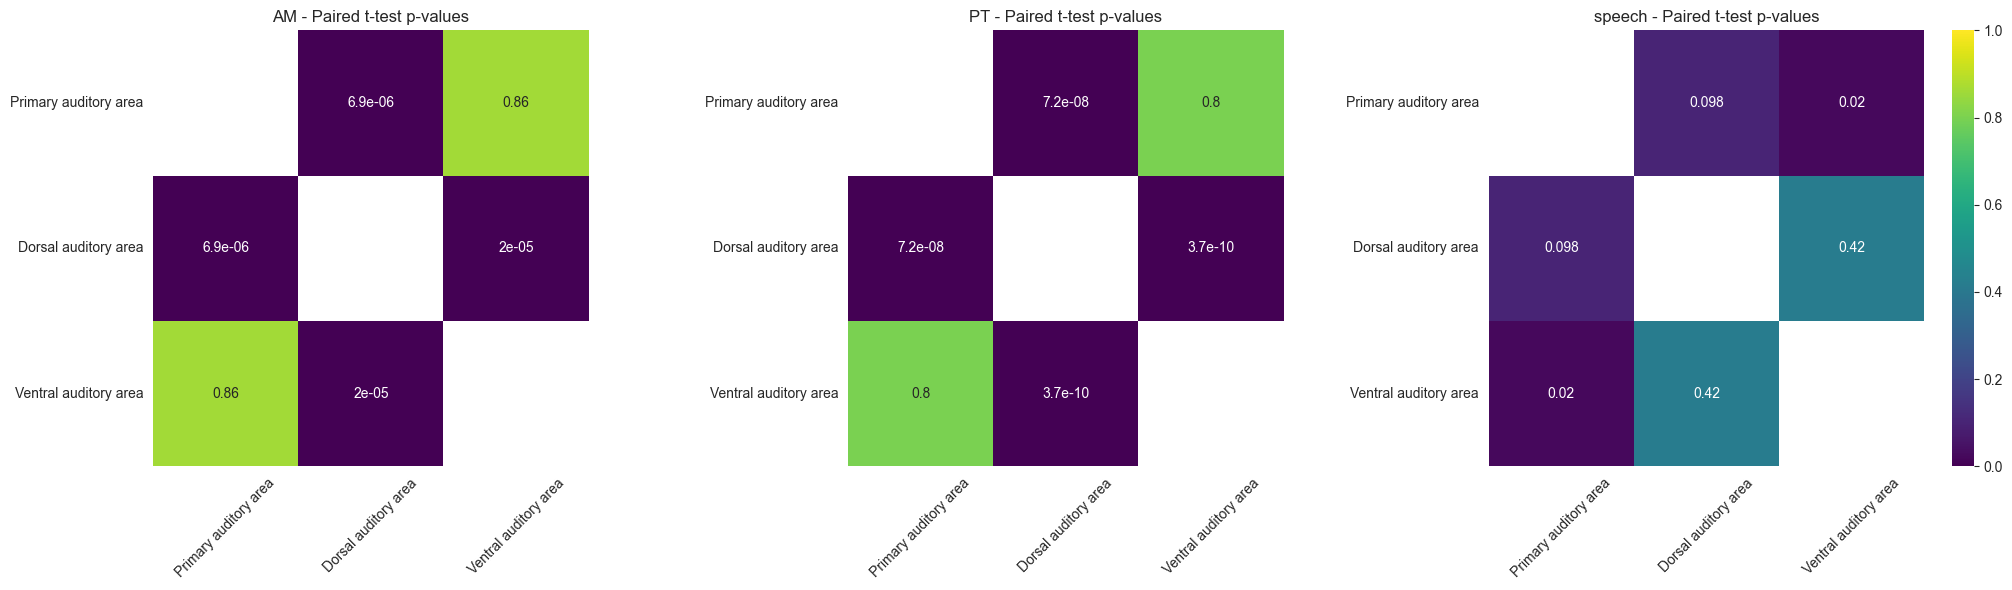

In [8]:
import pandas as pd
from scipy.stats import spearmanr, ttest_rel
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

fig_corr, axs_corr = plt.subplots(1, 3, figsize=(21, 6))
fig_pval, axs_pval = plt.subplots(1, 3, figsize=(21, 6))
significant_pairs = []

sound_types = ['AM', 'PT', 'speech']
areas = params.targetSiteNames  # Assuming this is a list of area names

for idx, sound_type in enumerate(sound_types):
    n_areas = len(areas)

    # Initialize correlation and p-value matrices
    corr_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
    pval_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
    annot_matrix = pd.DataFrame('', index=areas, columns=areas)

    combos = list(itertools.combinations(areas, 2))
    for brain1, brain2 in combos:
        matrix1 = dprime_matrices.get((brain1, sound_type))
        matrix2 = dprime_matrices.get((brain2, sound_type))

        if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
            print(f"Skipping {brain1} vs {brain2} for {sound_type} due to shape mismatch.")
            continue

        # Take only the upper triangle, excluding diagonal
        mask = np.triu(np.ones(matrix1.shape), k=1).astype(bool)
        flat1 = matrix1[mask]
        flat2 = matrix2[mask]

        # Spearman and paired t-test
        rho, spearman_p = spearmanr(flat1, flat2)
        t_stat, ttest_p = ttest_rel(flat1, flat2)
        
        if ttest_p < 0.05:
            significant_pairs.append((sound_type, brain1, brain2))

        # Fill matrices symmetrically
        corr_matrix.loc[brain1, brain2] = corr_matrix.loc[brain2, brain1] = rho
        pval_matrix.loc[brain1, brain2] = pval_matrix.loc[brain2, brain1] = ttest_p

        # Annotate Spearman with stars
        stars = '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else ''
        text = f"{rho:.2f}{stars}"
        annot_matrix.loc[brain1, brain2] = annot_matrix.loc[brain2, brain1] = text

    # Plot Spearman
    sns.heatmap(
        corr_matrix.astype(float),
        annot=annot_matrix.values,
        fmt='',
        cmap='viridis',
        vmin=-1,
        vmax=1,
        square=True,
        ax=axs_corr[idx],
        cbar=(idx == len(sound_types) - 1)
    )

    axs_corr[idx].set_title(f"{sound_type} - Spearman Correlation")
    axs_corr[idx].tick_params(axis='x', rotation=45)
    axs_corr[idx].tick_params(axis='y', rotation=0)

    # Plot Paired t-test p-values
    sns.heatmap(
        pval_matrix.astype(float),
        annot=True,
        cmap='viridis',
        vmin=0,
        vmax=1,
        square=True,
        ax=axs_pval[idx],
        cbar=(idx == len(sound_types) - 1)
    )

    # White-out diagonal
    for i in range(n_areas):
        axs_corr[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))
        axs_pval[idx].add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='white', lw=0))

    axs_pval[idx].set_title(f"{sound_type} - Paired t-test p-values")
    axs_pval[idx].tick_params(axis='x', rotation=45)
    axs_pval[idx].tick_params(axis='y', rotation=0)

fig_corr.tight_layout()
fig_pval.tight_layout()

fig_corr.savefig(os.path.join(save_path, "all_soundtypes_spearman_heatmaps.png"))
fig_pval.savefig(os.path.join(save_path, "all_soundtypes_ttest_pval_heatmaps.png"))

In [9]:
significant_pairs

[('AM', 'Primary auditory area', 'Dorsal auditory area'),
 ('AM', 'Dorsal auditory area', 'Ventral auditory area'),
 ('PT', 'Primary auditory area', 'Dorsal auditory area'),
 ('PT', 'Dorsal auditory area', 'Ventral auditory area'),
 ('speech', 'Primary auditory area', 'Ventral auditory area')]

In [10]:
# Collect data for d-prime boxplot
dprime_data = []

# Define custom color mapping
sound_order = ['PT', 'AM', 'speech']
sound_palette = {
    'PT': cm.winter(0.5),
    'AM': cm.magma(0.5),
    'speech': cm.summer(0.5)
}

for sound_type in sound_types:
    for area in areas:
        matrix = dprime_matrices.get((area, sound_type))

        if matrix is None:
            continue

        # Take only the upper triangle, excluding diagonal
        upper_triangle_mask = np.triu(np.ones(matrix.shape), k=1).astype(bool)
        flat_dprimes = matrix[upper_triangle_mask]

        for val in flat_dprimes:
            dprime_data.append({
                'Brain Area': area,
                'Sound': sound_type,
                'D-prime': val
            })

# Convert to DataFrame
dprime_df = pd.DataFrame(dprime_data)
dprime_df

,Brain Area,Sound,D-prime
0,Primary auditory area,AM,0.922832
1,Primary auditory area,AM,1.222048
2,Primary auditory area,AM,1.313835
3,Primary auditory area,AM,1.247372
4,Primary auditory area,AM,1.417984
...,...,...,...
718,Ventral auditory area,speech,0.316952
719,Ventral auditory area,speech,0.282218
720,Ventral auditory area,speech,0.239882
721,Ventral auditory area,speech,0.195331


In [11]:

from scipy.stats import f_oneway
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Store significant pairs for annotation
significant_pairs = []

# Perform one-way ANOVA + Tukey HSD per sound type
for sound_type in sound_order:
    # Extract d-prime values for each area
    group_data = [
        dprime_df[(dprime_df['Sound'] == sound_type) & (dprime_df['Brain Area'] == area)]['D-prime']
        for area in areas
    ]

    # Run one-way ANOVA
    f_stat, p_anova = f_oneway(*group_data)

    if p_anova < 0.05:
        # Run Tukey's HSD test for post-hoc pairwise comparisons
        subset_df = dprime_df[dprime_df['Sound'] == sound_type]
        tukey = pairwise_tukeyhsd(endog=subset_df['D-prime'],
                                  groups=subset_df['Brain Area'],
                                  alpha=0.05)

        # Extract significant pairs from Tukey HSD results
        for result in tukey.summary().data[1:]:  # skip header row
            area1, area2, _, _, _, p_adj, reject = result
            if reject:
                significant_pairs.append((sound_type, area1, area2))
                
significant_pairs

[('PT', 'Dorsal auditory area', 'Primary auditory area'),
 ('PT', 'Dorsal auditory area', 'Ventral auditory area')]

/var/folders/l9/v78y7h896278tzntj74hkdkr0000gn/T/ipykernel_47994/4164324226.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sound_order, fontsize=25)


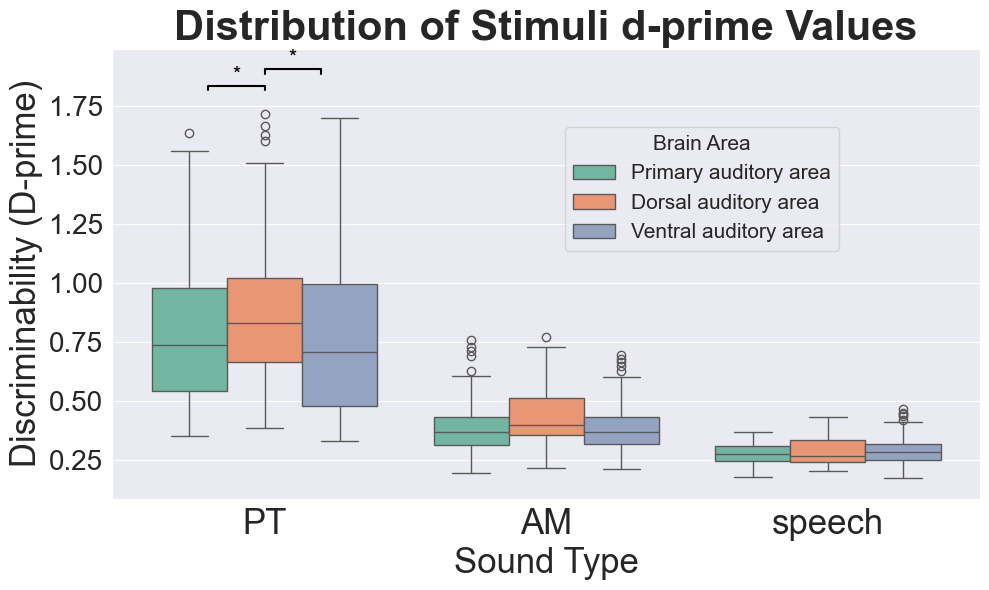

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=dprime_df,
    x='Sound',
    y='D-prime',
    hue='Brain Area',
    hue_order=areas,  # e.g., ['Primary', 'Dorsal', 'Ventral']
    palette='Set2',  # Or your own brain_area_palette if defined
    ax=ax
)

plt.title('Distribution of Stimuli d-prime Values', fontweight='bold', fontsize=30)

# Updated significance bar stacking logic
box_offsets = {area: i * 0.2 - 0.2 for i, area in enumerate(areas)}  # Offset by brain area

# Track top height for stacking
stack_base_y = dprime_df['D-prime'].max() + 0.1
stack_height = 0.07  # vertical spacing between stacked bars
stack_counter = 0

for sound, area1, area2 in significant_pairs:
    if area1 not in areas or area2 not in areas:
        continue

    x = sound_order.index(sound)  # sound is now on x-axis
    x1 = x + box_offsets[area1]
    x2 = x + box_offsets[area2]

    y = stack_base_y + stack_counter * stack_height

    ax.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], lw=1.5, c='k')
    ax.text((x1 + x2) / 2, y + 0.025, '*', ha='center', va='bottom', color='k', fontsize=15)
    stack_counter += 1

# Set axis labels
ax.set_ylabel('Discriminability (D-prime)', fontsize=25)
ax.set_xlabel("Sound Type", fontsize=25)

# Set tick label font sizes
ax.set_xticklabels(sound_order, fontsize=25)
ax.tick_params(axis='y', labelsize=20)

# Legend
legend = ax.legend(title='Brain Area', title_fontsize=15, fontsize=15, bbox_to_anchor=(0.85, 0.85))

plt.tight_layout()
plt.savefig(os.path.join(save_path, "boxplot_dprime_by_sound_and_area.png"))
plt.show()

In [14]:
for sound_type in sound_types:
    print(f"\n=== {sound_type.upper()} PAIRWISE COMPARISONS ===")
    combos = list(itertools.combinations(areas, 2))
    for brain1, brain2 in combos:
        matrix1 = dprime_matrices.get((brain1, sound_type))
        matrix2 = dprime_matrices.get((brain2, sound_type))

        if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
            print(f"Skipping {brain1} vs {brain2} (shape mismatch)")
            continue

        # Remove diagonal
        mask = ~np.eye(matrix1.shape[0], dtype=bool)
        flat1 = matrix1[mask]
        flat2 = matrix2[mask]

        # Paired t-test
        t_stat, p_val = ttest_rel(flat1, flat2)
        mean_diff = np.mean(flat1 - flat2)

        if mean_diff > 0:
            winner = brain1
        elif mean_diff < 0:
            winner = brain2
        else:
            winner = "Equal"

        print(f"{brain1} vs {brain2} | Δd′ = {mean_diff:.3f}, p = {p_val:.4f} → {winner} has higher d′")


=== AM PAIRWISE COMPARISONS ===
Primary auditory area vs Dorsal auditory area | Δd′ = -0.115, p = 0.0000 → Dorsal auditory area has higher d′
Primary auditory area vs Ventral auditory area | Δd′ = -0.002, p = 0.8642 → Ventral auditory area has higher d′
Dorsal auditory area vs Ventral auditory area | Δd′ = 0.113, p = 0.0000 → Dorsal auditory area has higher d′

=== PT PAIRWISE COMPARISONS ===
Primary auditory area vs Dorsal auditory area | Δd′ = -0.042, p = 0.0000 → Dorsal auditory area has higher d′
Primary auditory area vs Ventral auditory area | Δd′ = 0.001, p = 0.7198 → Primary auditory area has higher d′
Dorsal auditory area vs Ventral auditory area | Δd′ = 0.044, p = 0.0000 → Dorsal auditory area has higher d′

=== SPEECH PAIRWISE COMPARISONS ===
Primary auditory area vs Dorsal auditory area | Δd′ = -0.010, p = 0.0187 → Dorsal auditory area has higher d′
Primary auditory area vs Ventral auditory area | Δd′ = -0.015, p = 0.0009 → Ventral auditory area has higher d′
Dorsal auditor

# Below is d-prime PCA and Participation Analysis

In [ ]:
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

save_path = "/Users/zoetomlinson/Desktop/GitHub/neuronalDataResearch/Figures/Population Plots"
dprime_matrices = {}

num_iterations = 1000  # How many random samples per label
num_neurons = 60       # How many neurons per sample

# Define all unique speech labels (VOT, FT)
unique_labels = [(0, 0), (0, 33), (0, 67), (0, 100), (33, 100), (67, 100), (100, 100), (100, 67),
                 (100, 33), (100, 0), (67, 0), (33, 0)]

# Iterate over the sound types (AM, PT, speech)
sound_types = ['AM', 'PT', 'speech']
for sound_type in sound_types:
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns (for 3 brain areas)

    for idx, brain_area in enumerate(params.targetSiteNames):
        X_array = data_dict[(brain_area, sound_type)]['X']
        Y_array = data_dict[(brain_area, sound_type)]['Y']

        if sound_type == 'speech':
            if not isinstance(Y_array[0], tuple):
                Y_array = [tuple(label) for label in Y_array]
            unique_freqs = unique_labels
        else:
            unique_freqs = sorted(set(Y_array))

        # Initialize d-prime matrix
        dprime_array = np.zeros((len(unique_freqs), len(unique_freqs)))
        pr_dict = {}

        # Calculate participation ratios
        for label in unique_freqs:
            trials_label = [trial for trial, y in zip(X_array, Y_array) if y == label]
            trials_label = np.array(trials_label)

            pr_list = []
            # Sample 60 neurons 1000 times
            for _ in range(num_iterations):
                neuron_idx = np.random.choice(trials_label.shape[1], num_neurons, replace=False)
                sampled_trials = trials_label[:, neuron_idx]
            
                # Standardize data
                scaler = StandardScaler()
                data_standardized = scaler.fit_transform(sampled_trials)
            
                # Perform PCA
                pca = PCA()
                pca.fit(data_standardized)
                explained_variance_ratio = pca.explained_variance_ratio_
            
                # Compute participation ratio
                pr_value = funcs.calculate_participation_ratio(explained_variance_ratio)
                pr_list.append(pr_value)

            pr_dict[label] = np.array(pr_list)

        # Calculate d-prime based on participation ratios (from pr_dict)
        for i, freq1 in enumerate(unique_freqs):
            pr_freq1 = pr_dict[freq1]  # Get participation ratio for label 1
            mean_pr_freq1 = sum(pr_freq1) / len(pr_freq1)  # Mean participation ratio for label 1

            for j, freq2 in enumerate(unique_freqs):
                if i == j:
                    continue
                pr_freq2 = pr_dict[freq2]  # Get participation ratio for label 2
                mean_pr_freq2 = sum(pr_freq2) / len(pr_freq2)  # Mean participation ratio for label 2

                # Calculate Euclidean distance between the mean participation ratios
                distance_mean = 0
                for k in range(len(pr_freq1)):
                    distance_mean += (mean_pr_freq1 - mean_pr_freq2) ** 2
                distance_mean = distance_mean ** 0.5  # Take square root to get Euclidean distance

                # Compute inner-distance (intra-label distance)
                inner_distance_freq1 = sum(abs(pr - mean_pr_freq1) for pr in pr_freq1) / len(pr_freq1)
                inner_distance_freq2 = sum(abs(pr - mean_pr_freq2) for pr in pr_freq2) / len(pr_freq2)

                # Mean inner-distance (this is the denominator)
                denominator = (inner_distance_freq1 + inner_distance_freq2) / 2
                
                # Calculate d-prime
                dprime = distance_mean / denominator if denominator != 0 else 0
                dprime_array[i, j] = dprime

        dprime_matrices[(brain_area, sound_type)] = dprime_array

        # Format labels
        if sound_type == 'speech':
            x_labels = y_labels = [f"{vot},{ft}" for vot, ft in unique_freqs]
        else:
            x_labels = y_labels = unique_freqs

        # Plot the heatmap for d-prime matrix in the correct subplot for each brain area
        ax = axes[idx]
        sns.heatmap(dprime_array, annot=True, cmap='viridis', xticklabels=x_labels, yticklabels=y_labels, ax=ax)
        ax.set_title(f"{brain_area}", fontsize=16)
        ax.set_xlabel("Label 2")
        ax.set_ylabel("Label 1")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    fig.suptitle(f"D-prime Participation Ratio Heatmaps - {sound_type}", fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 0.96]) 
    filename = f"{sound_type}_PR_dprime_subplots.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, bbox_inches='tight')
    # plt.close()

In [ ]:
import pandas as pd
from scipy.stats import spearmanr, ttest_rel
import itertools
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

# Create 1x3 subplots
fig_corr, axs_corr = plt.subplots(1, 3, figsize=(21, 6))
fig_pval, axs_pval = plt.subplots(1, 3, figsize=(21, 6))

sound_types = ['AM', 'PT', 'speech']
areas = params.targetSiteNames

for idx, sound_type in enumerate(sound_types):
    n_areas = len(areas)

    # Initialize empty correlation and p-value DataFrames
    corr_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)
    pval_matrix = pd.DataFrame(np.nan, index=areas, columns=areas)

    # Loop through unique pairs of brain areas
    combos = list(itertools.combinations(areas, 2))
    for brain1, brain2 in combos:
        matrix1 = dprime_matrices.get((brain1, sound_type))
        matrix2 = dprime_matrices.get((brain2, sound_type))

        # Sanity check
        if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
            print(f"Skipping {brain1} vs {brain2} for {sound_type} due to shape mismatch.")
            continue

        # Flatten matrices, ignore diagonals (cause comparing PR of a label with itself = not interesting)
        mask = ~np.eye(matrix1.shape[0], dtype=bool)
        flat1 = matrix1[mask]
        flat2 = matrix2[mask]

        # Spearman correlation
        rho, spearman_p = spearmanr(flat1, flat2)
        # Paired t-test
        t_stat, ttest_p = ttest_rel(flat1, flat2)

        # Fill both upper and lower triangle
        corr_matrix.loc[brain1, brain2] = rho
        corr_matrix.loc[brain2, brain1] = rho
        pval_matrix.loc[brain1, brain2] = ttest_p
        pval_matrix.loc[brain2, brain1] = ttest_p

    # Plot Spearman correlation heatmap
    sns.heatmap(corr_matrix.astype(float), annot=True, cmap='viridis', vmin=-1, vmax=1,
                square=True, ax=axs_corr[idx], cbar=(idx == len(sound_types) - 1),
                cbar_kws={"shrink": 0.8})
    axs_corr[idx].set_title(f"{sound_type} - Spearman Correlation", fontsize=16)
    axs_corr[idx].tick_params(axis='x', rotation=45)
    axs_corr[idx].tick_params(axis='y', rotation=0)

    # Plot paired t-test p-value heatmap
    sns.heatmap(pval_matrix.astype(float), annot=True, cmap='viridis', vmin=0, vmax=1,
                square=True, ax=axs_pval[idx], cbar=(idx == len(sound_types) - 1),
                cbar_kws={"shrink": 0.8})
    axs_pval[idx].set_title(f"{sound_type} - Paired t-test p-values", fontsize=16)
    axs_pval[idx].tick_params(axis='x', rotation=45)
    axs_pval[idx].tick_params(axis='y', rotation=0)

# Tidy layout
fig_corr.suptitle("Spearman Correlations Between Brain Areas (D-prime PR)", fontsize=20, y=1.02)
fig_pval.suptitle("Paired t-test P-values Between Brain Areas (D-prime PR)", fontsize=20, y=1.02)
fig_corr.tight_layout()
fig_pval.tight_layout()

# Save
fig_corr.savefig(os.path.join(save_path, "all_soundtypes_spearman_heatmaps.png"), bbox_inches='tight')
fig_pval.savefig(os.path.join(save_path, "all_soundtypes_ttest_pval_heatmaps.png"), bbox_inches='tight')

# Optional close
# plt.close(fig_corr)
# plt.close(fig_pval)

In [ ]:
# Collect data for d-prime boxplot (PR version)
dprime_data = []

for sound_type in sound_types:
    for area in areas:
        matrix = dprime_matrices.get((area, sound_type))

        if matrix is None:
            continue

        # Flatten off-diagonal d-prime values
        mask = ~np.eye(matrix.shape[0], dtype=bool)
        flat_dprimes = matrix[mask]

        for val in flat_dprimes:
            dprime_data.append({
                'Brain Area': area,
                'Sound': sound_type,
                'D-prime': val
            })

# Make into DataFrame
dprime_df = pd.DataFrame(dprime_data)

# Plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=dprime_df, x='Brain Area', y='D-prime', hue='Sound',
            palette='Set2', width=0.6, linewidth=1.5, fliersize=3)

plt.title('D-prime (PR) by Brain Area and Sound Type', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Brain Area', fontsize=14)
plt.ylabel('D-prime', fontsize=14)
plt.legend(title='Sound Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, "boxplot_PR_dprime_by_area_and_sound.png"))
plt.show()

In [ ]:
# Collect data for d-prime boxplot (PR version)
dprime_data = []

for sound_type in sound_types:
    for area in areas:
        matrix = dprime_matrices.get((area, sound_type))

        if matrix is None:
            continue

        # Flatten off-diagonal d-prime values
        mask = ~np.eye(matrix.shape[0], dtype=bool)
        flat_dprimes = matrix[mask]

        for val in flat_dprimes:
            dprime_data.append({
                'Brain Area': area,
                'Sound': sound_type,
                'D-prime': val
            })

# Make into DataFrame
dprime_df = pd.DataFrame(dprime_data)

# Plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=dprime_df, x='Brain Area', y='D-prime', hue='Sound',
            palette='Set2', width=0.6, linewidth=1.5, fliersize=3)

plt.title('D-prime (PR) by Brain Area and Sound Type', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Brain Area', fontsize=14)
plt.ylabel('D-prime', fontsize=14)
plt.legend(title='Sound Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(save_path, "boxplot_PR_dprime_by_area_and_sound.png"))
plt.show()

In [ ]:
for sound_type in sound_types:
    print(f"\n=== {sound_type.upper()} PAIRWISE COMPARISONS ===")
    combos = list(itertools.combinations(areas, 2))
    for brain1, brain2 in combos:
        matrix1 = dprime_matrices.get((brain1, sound_type))
        matrix2 = dprime_matrices.get((brain2, sound_type))

        if matrix1 is None or matrix2 is None or matrix1.shape != matrix2.shape:
            print(f"Skipping {brain1} vs {brain2} (shape mismatch)")
            continue

        # Remove diagonal
        mask = ~np.eye(matrix1.shape[0], dtype=bool)
        flat1 = matrix1[mask]
        flat2 = matrix2[mask]

        # Paired t-test
        t_stat, p_val = ttest_rel(flat1, flat2)
        mean_diff = np.mean(flat1 - flat2)

        if mean_diff > 0:
            winner = brain1
        elif mean_diff < 0:
            winner = brain2
        else:
            winner = "Equal"

        print(f"{brain1} vs {brain2} | Δd′ = {mean_diff:.3f}, p = {p_val:.4f} → {winner} has higher d′")

In [5]:
import numpy as np

# Generate toy neural data
np.random.seed(42)  # for reproducibility

n_trials = 200
n_neurons = 300

# Two different stimulus frequencies (or classes)
freq1 = 40
freq2 = 60

# Assign half of the trials to freq1, half to freq2
Y_test_data = np.array([freq1] * (n_trials // 2) + [freq2] * (n_trials // 2)).reshape(-1, 1)

# Shuffle Y to simulate random trial ordering
np.random.shuffle(Y_test_data)

# Simulate X data (e.g., neural responses)
# Make freq1 and freq2 groups have different mean activity to test discriminability
X_test_data = np.random.randn(n_trials, n_neurons)  # base noise
X_test_data[Y_test_data.flatten() == freq1] += 0.5  # shift freq1 trials a bit
X_test_data.shape, Y_test_data.shape

((200, 300), (200, 1))

In [7]:
trials_freq1 = X_test_data[Y_test_data == freq1]  # (trials, neurons)
trials_freq1

IndexError: boolean index did not match indexed array along dimension 1; dimension is 300 but corresponding boolean dimension is 1

In [ ]:
avg_freq1 = np.mean(trials_freq1, axis=0)  # (neurons,)

trials_freq2 = X_test_data[Y_test_data == freq2]
avg_freq2 = np.mean(trials_freq2, axis=0)

numerator = np.linalg.norm(avg_freq1 - avg_freq2)

# distances of each trial to its group mean
distances_freq1 = np.linalg.norm(trials_freq1 - avg_freq1, axis=1)  # (trials,)
distances_freq2 = np.linalg.norm(trials_freq2 - avg_freq2, axis=1)  # (trials,)

denominator = (np.sum(distances_freq1) + np.sum(distances_freq2)) / (len(distances_freq1) + len(distances_freq2))

dprime = numerator / denominator if denominator != 0 else 0
dprime_array[i, j] = dprime

No FTVOTBorder data for Primary auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Primary auditory area.
No FTVOTBorder data for Dorsal auditory area on 2022-01-11 for feat004
Not enough PT trials recorded for subject feat004, on 2022-01-11 in brain area Dorsal auditory area.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-11 for Speech, AM, and PT.
No FTVOTBorder data for Primary auditory area on 2022-01-19 for feat004
No FTVOTBorder data for Dorsal auditory area on 2022-01-19 for feat004
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-19 for Speech, AM, and PT.
No data in Ventral auditory area on 2022-01-21 for Speech, AM, and PT.
No data in Ven

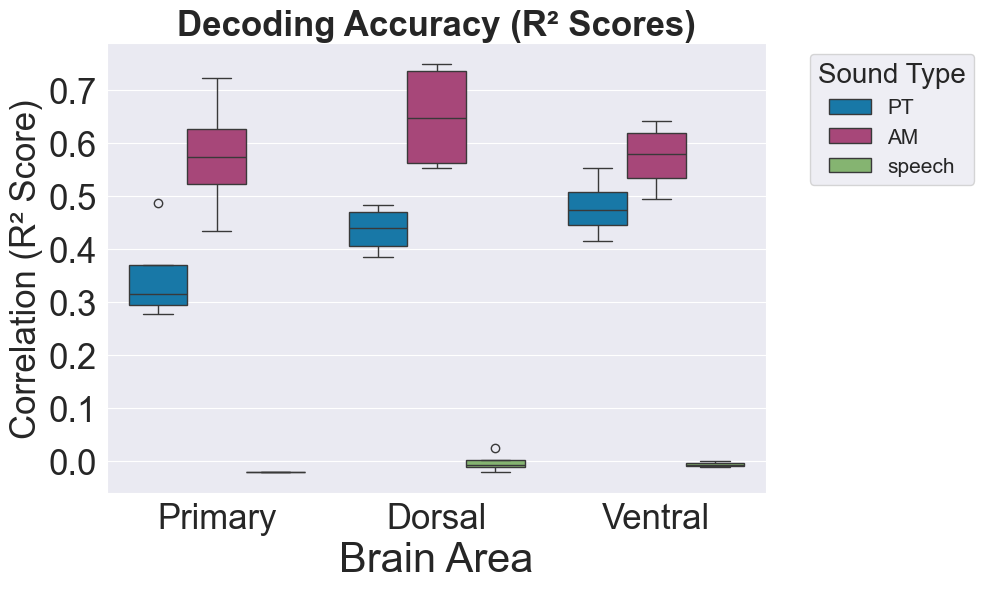

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from jaratoolbox import celldatabase, settings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import funcs
import seaborn as sns
import params
# %% Constants
subject_list = ['feat004', 'feat005', 'feat006', 'feat007', 'feat008', 'feat009']  # 'feat010'
recordingDate_list = {
    'feat004': ['2022-01-11', '2022-01-19', '2022-01-21'],
    'feat005': ['2022-02-07', '2022-02-08', '2022-02-11', '2022-02-14', '2022-02-15', '2022-02-16'],
    'feat006': ['2022-02-21', '2022-02-22', '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-28', '2022-03-01', '2022-03-02'],
    'feat007': ['2022-03-10', '2022-03-11', '2022-03-15', '2022-03-16', '2022-03-18', '2022-03-21'],
    'feat008': ['2022-03-23', '2022-03-24', '2022-03-25'],
    'feat009': ['2022-06-04', '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-09', '2022-06-10'],
    'feat010': ['2022-06-21', '2022-06-22', '2022-06-27', '2022-06-28', '2022-06-30']
}
targetSiteNames = ["Primary auditory area", "Dorsal auditory area", "Ventral auditory area"]
leastCellsArea = 10000
evoked_start = 0.015
evoked_end = 0.3
pt_evoked_end = 0.1
binWidth = 0.01
binEdges = np.arange(evoked_start, evoked_end, binWidth)
binEdgesPT = np.arange(evoked_start, pt_evoked_end, binWidth)
iterations = 30  # Number of random sampling iterations
random_seed = 42
alphas = np.logspace(-5, 10, 200)
np.random.seed(random_seed)  # Ensure reproducibility
periodsNameSpeech = ['base200', 'respOnset', 'respSustained']
max_trials = {'PT': 640, 'AM': 220, 'speech': 381}
unique_labels = [(0, 0), (0, 33), (0, 67), (0, 100), (33, 100), (67, 100), (100, 100), (100, 67), (100, 33),
                 (100, 0), (67, 0), (33, 0)]
min_speech_freq_dict = {(0, 0): 31, (0, 33): 29, (0, 67): 32, (0, 100): 24, (33, 100): 34, (67, 100): 35,
                        (100, 100): 33, (100, 67): 29, (100, 33): 35, (100, 0): 35, (67, 0): 31, (33, 0): 33}
# Initialize a dictionary to store counts for each frequency across mouse-date combos
frequency_counts_dict = {tuple(freq): [] for freq in unique_labels}
data_dict = {}
previous_frequency_speech = None
previous_frequency_AM = None
previous_frequency_PT = None
n_neurons_list = []
r2_test_list = []
labels_list = []
primary_n_neurons = 0
ventral_n_neurons = 0
dorsal_n_neurons = 0
indices_AM = None
results = []
smallest_neuron_count = 10
X_speech_all = []
Y_brain_area_speech_all = []
X_AM_all = []
Y_brain_area_AM_all = []
X_pureTones_all = []
Y_brain_area_PT_all = []


# %% Load Data
databaseDir = os.path.join(settings.DATABASE_PATH, '2022paspeech')
fullDbPath = 'fulldb_speech_tuning.h5'
fullPath = os.path.join(databaseDir, fullDbPath)
fullDb = celldatabase.load_hdf(fullPath)
simpleSiteNames = fullDb["recordingSiteName"].str.split(',').apply(lambda x: x[0])
simpleSiteNames = simpleSiteNames.replace("Posterior auditory area", "Dorsal auditory area")
fullDb["recordingSiteName"] = simpleSiteNames

# Add data to the dictionary for each brain area and sound type
for subject in params.subject_list:
    for date in params.recordingDate_list[subject]:
        for brain_area in params.targetSiteNames:
            speechEnsemble, speechEphys, speechBdata = funcs.load_data(subject, date, brain_area, "FTVOTBorders")

            if speechEnsemble:
                X_speech, Y_brain_area_speech, Y_frequency_speech = funcs.spike_rate("speech", speechEnsemble,
                                                                    speechEphys, speechBdata, brain_area)

                X_speech_array, Y_frequency_speech_sorted, previous_frequency_speech, indices_speech = (
                    funcs.adjust_speech_length(subject, date, brain_area, X_speech, Y_frequency_speech,
                                               Y_brain_area_speech, previous_frequency_speech))

                if X_speech_array is not None:
                    # Y_frequency_FT = Y_frequency_speech_sorted[:, 0]
                    # Y_frequency_VOT = Y_frequency_speech_sorted[:, 1]
                    X_speech_all.extend(X_speech_array)
                    Y_brain_area_speech_all.extend(Y_brain_area_speech)

            # Load and process data for AM
            amEnsemble, amEphys, amBdata = funcs.load_data(subject, date, brain_area, "AM")
            if amEnsemble:
                X_AM, Y_brain_area_AM, Y_frequency_AM = funcs.spike_rate(
                    "AM", amEnsemble, amEphys, amBdata, brain_area)

                # Apply adjustments
                X_AM_adjusted, Y_frequency_AM_adjusted, Yba_AM_adj = (
                    funcs.adjust_array_and_labels(X_AM, Y_frequency_AM, Y_brain_area_AM,
                                                  params.max_trials['AM'], subject, date, brain_area))

                # Sort arrays
                X_AM_array, Y_frequency_AM_sorted, Y_brain_area_AM_sorted, previous_frequency_AM, indices_AM = (
                    funcs.sort_sound_array(subject, date, brain_area, X_AM_adjusted, Yba_AM_adj, Y_frequency_AM_adjusted, previous_frequency_AM))

                if X_AM_array is not None:
                    # Append the data to the lists
                    X_AM_all.extend(X_AM_array)
                    Y_brain_area_AM_all.extend(Y_brain_area_AM_sorted)

            # Load and process data for Pure Tones
            ptEnsemble, ptEphys, ptBdata = funcs.load_data(subject, date, brain_area, "pureTones")
            if ptEnsemble:
                X_pureTones, Y_brain_area_PT, Y_frequency_pureTones = funcs.spike_rate(
                    "PT", ptEnsemble, ptEphys, ptBdata, brain_area)

                # Apply adjustments
                X_PT_adjusted, Y_frequency_PT_adjusted, Yba_PT_adj = (
                    funcs.adjust_array_and_labels(X_pureTones, Y_frequency_pureTones, Y_brain_area_PT,
                                                  params.max_trials['PT'], subject, date, brain_area))

                # Sort arrays
                X_PT_array, Y_frequency_PT_sorted, Y_brain_area_PT_sorted, previous_frequency_PT, indices_PT = (
                    funcs.sort_sound_array(subject, date, brain_area, X_PT_adjusted, Yba_PT_adj, Y_frequency_PT_adjusted, previous_frequency_PT))

                if X_PT_array is not None:
                    X_pureTones_all.extend(X_PT_array)
                    Y_brain_area_PT_all.extend(Y_brain_area_PT_sorted)

# %% Sort arrays
X_PT_sorted = funcs.sort_x_arrays(X_pureTones_all, indices_PT, "pt")
X_AM_sorted = funcs.sort_x_arrays(X_AM_all, indices_AM, "am")
X_speech_sorted = funcs.sort_x_arrays(X_speech_all, indices_speech, "speech")

# Convert the lists to numpy arrays for easy manipulation
X_speech_array = np.stack(X_speech_sorted, axis=0)
# X_speech_array = X_speech_array.squeeze(axis=1)
X_AM_array = np.stack(X_AM_sorted, axis=0)
X_PT_array = np.stack(X_PT_sorted, axis=0)

# Initialize a dictionary to store 2D arrays for each brain_area - sound_type combo
data_dict = {}

for subject in subject_list:
    for brain_area in params.targetSiteNames:
        for sound_type, X_array, Y_brain_area_all, Y_frequency_sorted in zip(
                ['AM', 'PT', 'speech'],
                [X_AM_array, X_PT_array, X_speech_array],
                [Y_brain_area_AM_all, Y_brain_area_PT_all, Y_brain_area_speech_all],
                [Y_frequency_AM_sorted, Y_frequency_PT_sorted, Y_frequency_speech_sorted]):

            # Filter data based on the brain_area
            brain_area_array = np.array(Y_brain_area_all)
            X_array_adjusted = X_array[brain_area_array == brain_area]  # X is neurons x trials

            # Store the 2D array (neurons x trials) in the dictionary
            data_dict[(subject, brain_area, sound_type)] = {
                'X': X_array_adjusted.T,  # Transpose to get the correct shape (neurons x trials)
                'Y': np.array(Y_frequency_sorted)}  # Y is a 1D array of frequencies

# %% Ridge Regression
for key, value in data_dict.items():
    X = value['X']
    if (key[0] == 'feat004' or key[0] == 'feat006') and (key[1] == 'Primary auditory area' or key[1] == 'Ventral auditory area'):
        continue  # dont include this data because there arent enough neurons
    if (key[0] == 'feat008' or key[0] == 'feat009') and key[1] == 'Dorsal auditory area':
        continue
    smallest_neuron_count = 60

    if key[1] == 'AM' or key[1] == 'PT':
        Y = np.log(value['Y'])
    else:
        Y = value['Y']

    # Sampling iterations
    sampled_indices = np.random.choice(X.shape[1], smallest_neuron_count, replace=False)
    X_sampled = X[:, sampled_indices]
    n_neurons = X_sampled.shape[1]

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y, test_size=0.2,
                                                        random_state=random_seed)
    # Check if the array is empty before fitting the model
    if X_train.shape[1] == 0:
        print(f"Skipping {key[0]} - {key[1]} - {key[2]} due to empty feature array.")
        continue  # Skip this iteration

    # Find best alpha using Ridge Regression
    best_r2, best_alpha = -np.inf, None
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, Y_train)
        r2 = ridge.score(X_test, Y_test)
        if r2 > best_r2:
            best_r2 = r2
            best_alpha = alpha

    # Append results
    results.append({
        'Subject': key[0],
        'Brain Area': key[1],
        'Sound Type': key[2],
        'R2 Test': best_r2
        })

    if key[1] == "Primary auditory area":
        primary_n_neurons += n_neurons
    elif key[1] == "Dorsal auditory area":
        dorsal_n_neurons += n_neurons
    else:
        ventral_n_neurons += n_neurons

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Compute the average R² for each Subject, Brain Area, and Sound Type
average_r2_df = results_df.groupby(['Subject', 'Brain Area', 'Sound Type'], as_index=False)['R2 Test'].mean()
from matplotlib import cm

# Define consistent order for sound types
sound_order = ['PT', 'AM', 'speech']

# Map sound types to specific colors from different colormaps
sound_cmaps = {
    "PT": cm.winter(0.5),
    "AM": cm.magma(0.5),
    "speech": cm.summer(0.5),
}

# Plot with white background and color mapping
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=average_r2_df,
    x='Brain Area',
    y='R2 Test',
    hue='Sound Type',
    order=["Primary auditory area", "Dorsal auditory area", "Ventral auditory area"],
    hue_order=sound_order,
    palette=[sound_cmaps[sound] for sound in sound_order],
    ax=ax
)

# Style the plot
plt.title("Decoding Accuracy (R² Scores)", fontsize=25, fontweight='bold')
plt.xlabel("Brain Area", fontsize=30)
plt.ylabel("Correlation (R² Score)", fontsize=25)
plt.xticks(
    ticks=[0, 1, 2],  # or whatever tick positions you have
    labels=['Primary', 'Dorsal', 'Ventral'],
    fontsize=25)
plt.yticks(fontsize=25)
plt.legend(title='Sound Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15, title_fontsize=20)
plt.tight_layout()

# Save the plot
plt.savefig("/Users/zoetomlinson/Desktop/GitHub/neuronalDataResearch/Figures/Ridge Regression/R2_BoxPlot_Poster.png")
plt.show()

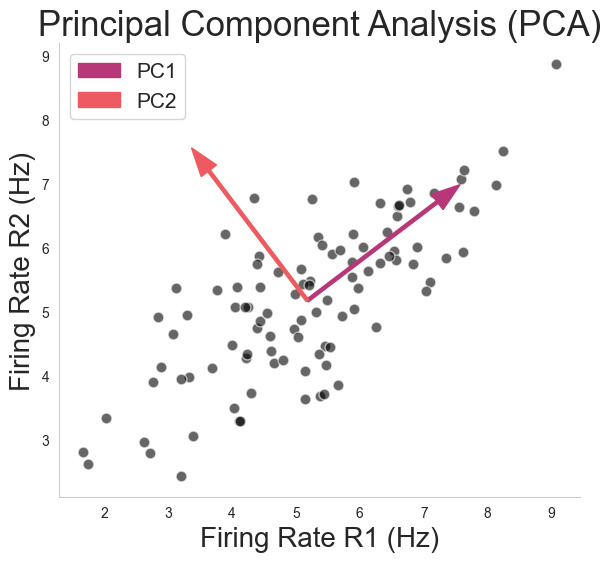

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import cm

# Simulate firing rate data
np.random.seed(42)
mean = [5, 5]
cov = [[3, 2], [2, 2]]  # correlated firing between neurons
data = np.random.multivariate_normal(mean, cov, 100)

# Perform PCA
pca = PCA(n_components=2)
pca.fit(data)
components = pca.components_
mean_point = np.mean(data, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(data[:, 0], data[:, 1], alpha=0.6,color='black', edgecolor='white', s=60)
ax.set_xlabel("Firing Rate R1 (Hz)", fontsize=20)
ax.set_ylabel("Firing Rate R2 (Hz)", fontsize=20)
ax.set_title("Principal Component Analysis (PCA)", fontsize=25)

# Define colors for the arrows
colors = [cm.magma(0.5), cm.magma(0.65)]

# Draw PCA axes
for i, (vec, color) in enumerate(zip(components, colors)):
    ax.arrow(mean_point[0], mean_point[1],
             vec[0]*3, vec[1]*3,
             color=color, width=0.05,
             head_width=0.3, length_includes_head=True,
             label=f"PC{i+1}")

# Styling
ax.spines[['top', 'right']].set_visible(False)
ax.grid(False)
ax.set_aspect('equal')
ax.legend(loc="upper left", fontsize=15)
plt.tight_layout()
plt.show()


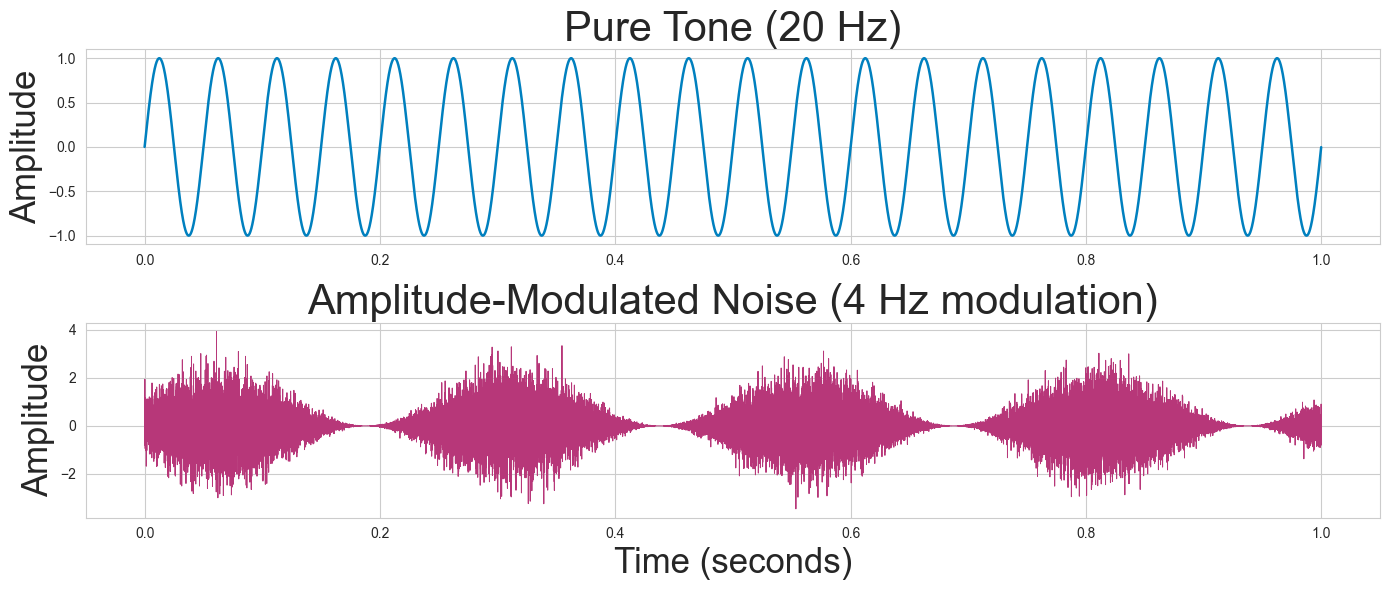

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
fs = 44100  # sampling rate in Hz
duration = 1.0  # duration in seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Pure tone parameters
freq = 20  # Hz
pure_tone = np.sin(2 * np.pi * freq * t)

# AM noise parameters
modulation_freq = 4  # Hz
modulation = 0.5 * (1 + np.sin(2 * np.pi * modulation_freq * t))  # modulation envelope
white_noise = np.random.normal(0, 1, len(t))
am_signal = modulation * white_noise

# Create figure
plt.figure(figsize=(14, 6))

# Plot pure tone
plt.subplot(2, 1, 1)
plt.plot(t, pure_tone, color=cm.winter(0.5), linewidth=1.8)
plt.title("Pure Tone (20 Hz)", fontsize=30)
plt.ylabel("Amplitude", fontsize=25)

# Plot AM noise
plt.subplot(2, 1, 2)
plt.plot(t, am_signal, color=cm.magma(0.5), linewidth=0.7)
plt.title("Amplitude-Modulated Noise (4 Hz modulation)", fontsize=30)
plt.xlabel("Time (seconds)", fontsize=25)
plt.ylabel("Amplitude", fontsize=25)

plt.tight_layout()
plt.show()


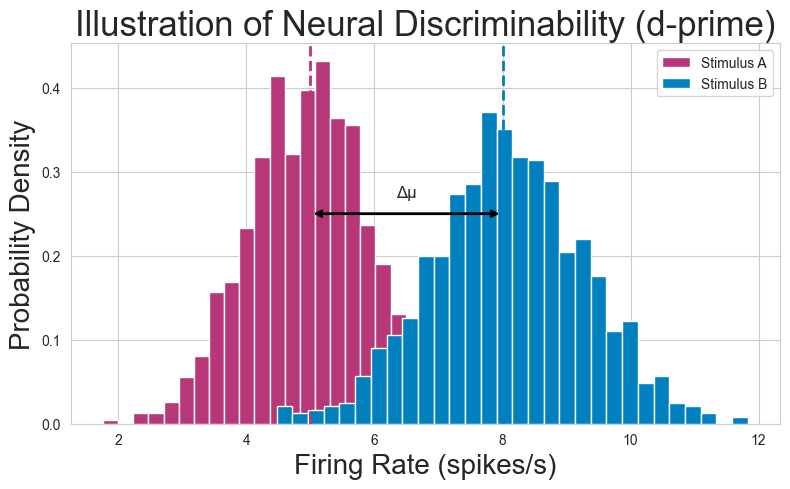

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic firing rate data for two conditions
mu1, sigma1 = 5, 1  # Mean and std for condition 1
mu2, sigma2 = 8, 1.2  # Mean and std for condition 2

data1 = np.random.normal(mu1, sigma1, 1000)
data2 = np.random.normal(mu2, sigma2, 1000)

# Colors using specified colormaps
color1 = cm.magma(0.5)
color2 = cm.winter(0.5)

# Plotting
plt.figure(figsize=(8, 5))
plt.hist(data1, bins=30, density=True,  color=color1, label='Stimulus A')
plt.hist(data2, bins=30, density=True,  color=color2, label='Stimulus B')

# Add mean lines
plt.axvline(mu1, color=color1, linestyle='--', linewidth=2)
plt.axvline(mu2, color=color2, linestyle='--', linewidth=2)

# Add arrows to show d-prime concept
plt.annotate('', xy=(mu1, 0.25), xytext=(mu2, 0.25),
             arrowprops=dict(arrowstyle='<->', color='black', lw=2))
plt.text((mu1 + mu2) / 2, 0.27, 'Δμ', ha='center', fontsize=12)

# Labels and legend
plt.title('Illustration of Neural Discriminability (d-prime)', fontsize=25)
plt.xlabel('Firing Rate (spikes/s)', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()
